# Read csv files

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
os.makedirs("outputs", exist_ok=True)

def read_file():
    """
    Reads a CSV file and returns a DataFrame.
    """
    csv_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data", "csv")
    print("CSV directory:", csv_dir)
    csv_files = glob.glob(os.path.join(csv_dir, "sf_crime_*.csv.gz"))
    print("CSV files found:", csv_files)

    if csv_files:
        file_path = max(csv_files, key=os.path.getctime)
    else:
        return None

    try:
        df = pd.read_csv(file_path, compression='gzip', low_memory=False)

        # Convert 'incident_datetime' to datetime and extract hour, weekday, and month
        df['incident_datetime'] = pd.to_datetime(df['incident_datetime'], errors='coerce')
        df['incident_hour'] = df['incident_datetime'].dt.hour
        df['incident_month'] = df['incident_datetime'].dt.month
        df = df.dropna(subset=['latitude', 'longitude', 'incident_datetime', 'incident_category'])


        print(f"df shape: {df.shape}")
        print(f"df columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

df = read_file()
        

CSV directory: /Users/chichichen/Code/ecs273-team08-CrimeForecast/data/csv
CSV files found: ['/Users/chichichen/Code/ecs273-team08-CrimeForecast/data/csv/sf_crime_20240530_20250524.csv.gz']
df shape: (70852, 30)
df columns: ['incident_datetime', 'incident_date', 'incident_time', 'incident_year', 'incident_day_of_week', 'report_datetime', 'row_id', 'incident_id', 'incident_number', 'cad_number', 'report_type_code', 'report_type_description', 'incident_code', 'incident_category', 'incident_subcategory', 'incident_description', 'resolution', 'intersection', 'cnn', 'police_district', 'analysis_neighborhood', 'supervisor_district', 'supervisor_district_2012', 'latitude', 'longitude', 'point', 'filed_online', 'location', 'incident_hour', 'incident_month']


# 1. Top 10 crime Categories

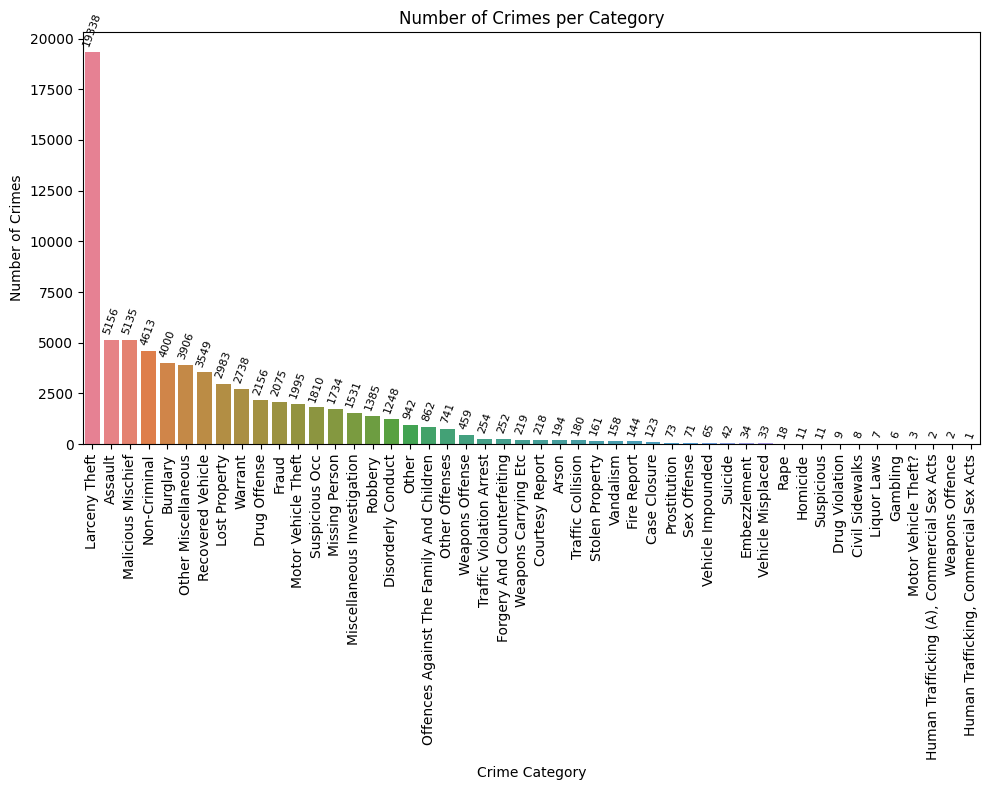

In [ ]:
category_counts = df['incident_category'].value_counts()

plt.figure(figsize=(10, 8))
palette = sns.color_palette("husl", len(category_counts))

ax = sns.barplot(
    x=category_counts.index,
    y=category_counts.values,
    palette=palette,
    hue=category_counts.index
)

for i, v in enumerate(category_counts.values):
    ax.text(i, v + max(category_counts.values)*0.01, str(v), ha='center', va='bottom', fontsize=8, rotation=70)


plt.xticks(rotation=90)

plt.title("Number of Crimes per Category")
plt.xlabel("Crime Category")
plt.ylabel("Number of Crimes")

plt.tight_layout()

plt.savefig("outputs/crime_categories.png", dpi=300)
plt.show()

# 2. Crime by Hour

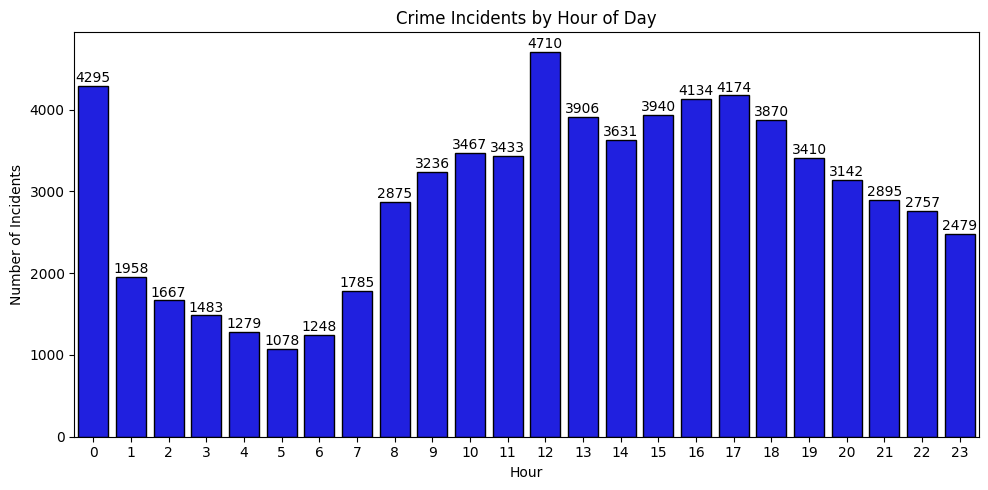

In [109]:
plt.figure(figsize=(10, 5))
hour_counts = df['incident_hour'].value_counts().sort_index()
ax = sns.barplot(x=hour_counts.index, y=hour_counts.values, color='blue', edgecolor='black')

for i, v in enumerate(hour_counts.values):
    ax.text(i, v + max(hour_counts.values)*0.01, str(v), color='black', ha='center')

plt.title("Crime Incidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Incidents")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.savefig("outputs/crime_by_hour.png")
plt.show()

# 3. Crime by Weekday

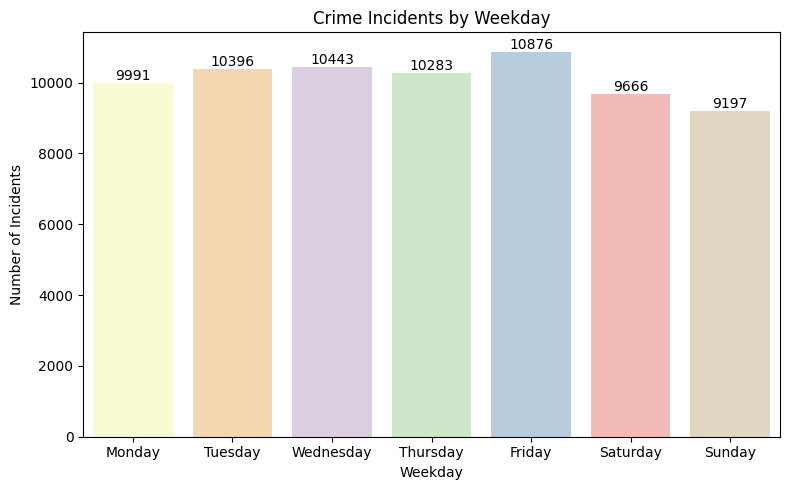

In [113]:
plt.figure(figsize=(8, 5))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.countplot(data=df, x='incident_weekday', hue='incident_weekday', order=weekday_order, palette='Pastel1')

for p in ax.patches:
    count = int(p.get_height())  
    ax.text(p.get_x() + p.get_width() / 2, count + 1, str(count), ha='center', va='bottom', color='black')


plt.title("Crime Incidents by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Incidents")
plt.tight_layout()
plt.savefig("outputs/crime_by_weekday.png")
plt.show()

# 4. Crime Location Density Heatmap

In [98]:
plt.figure(figsize=(10, 8))
sns.kdeplot(
    x=df['longitude'], 
    y=df['latitude'], 
    cmap="Reds", 
    fill=True, 
    thresh=0.05
)
plt.title("Crime Location Density in San Francisco")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.savefig("outputs/crime_heatmap.png")
plt.close()

# 5. Top 11 Crime Heatmap <br>
(per category data that is more than2000)

In [ ]:
import contextily as ctx
from shapely.geometry import Point
import geopandas as gpd

top11 = df['incident_category'].value_counts().nlargest(11).index
df_top11 = df[df['incident_category'].isin(top11)]

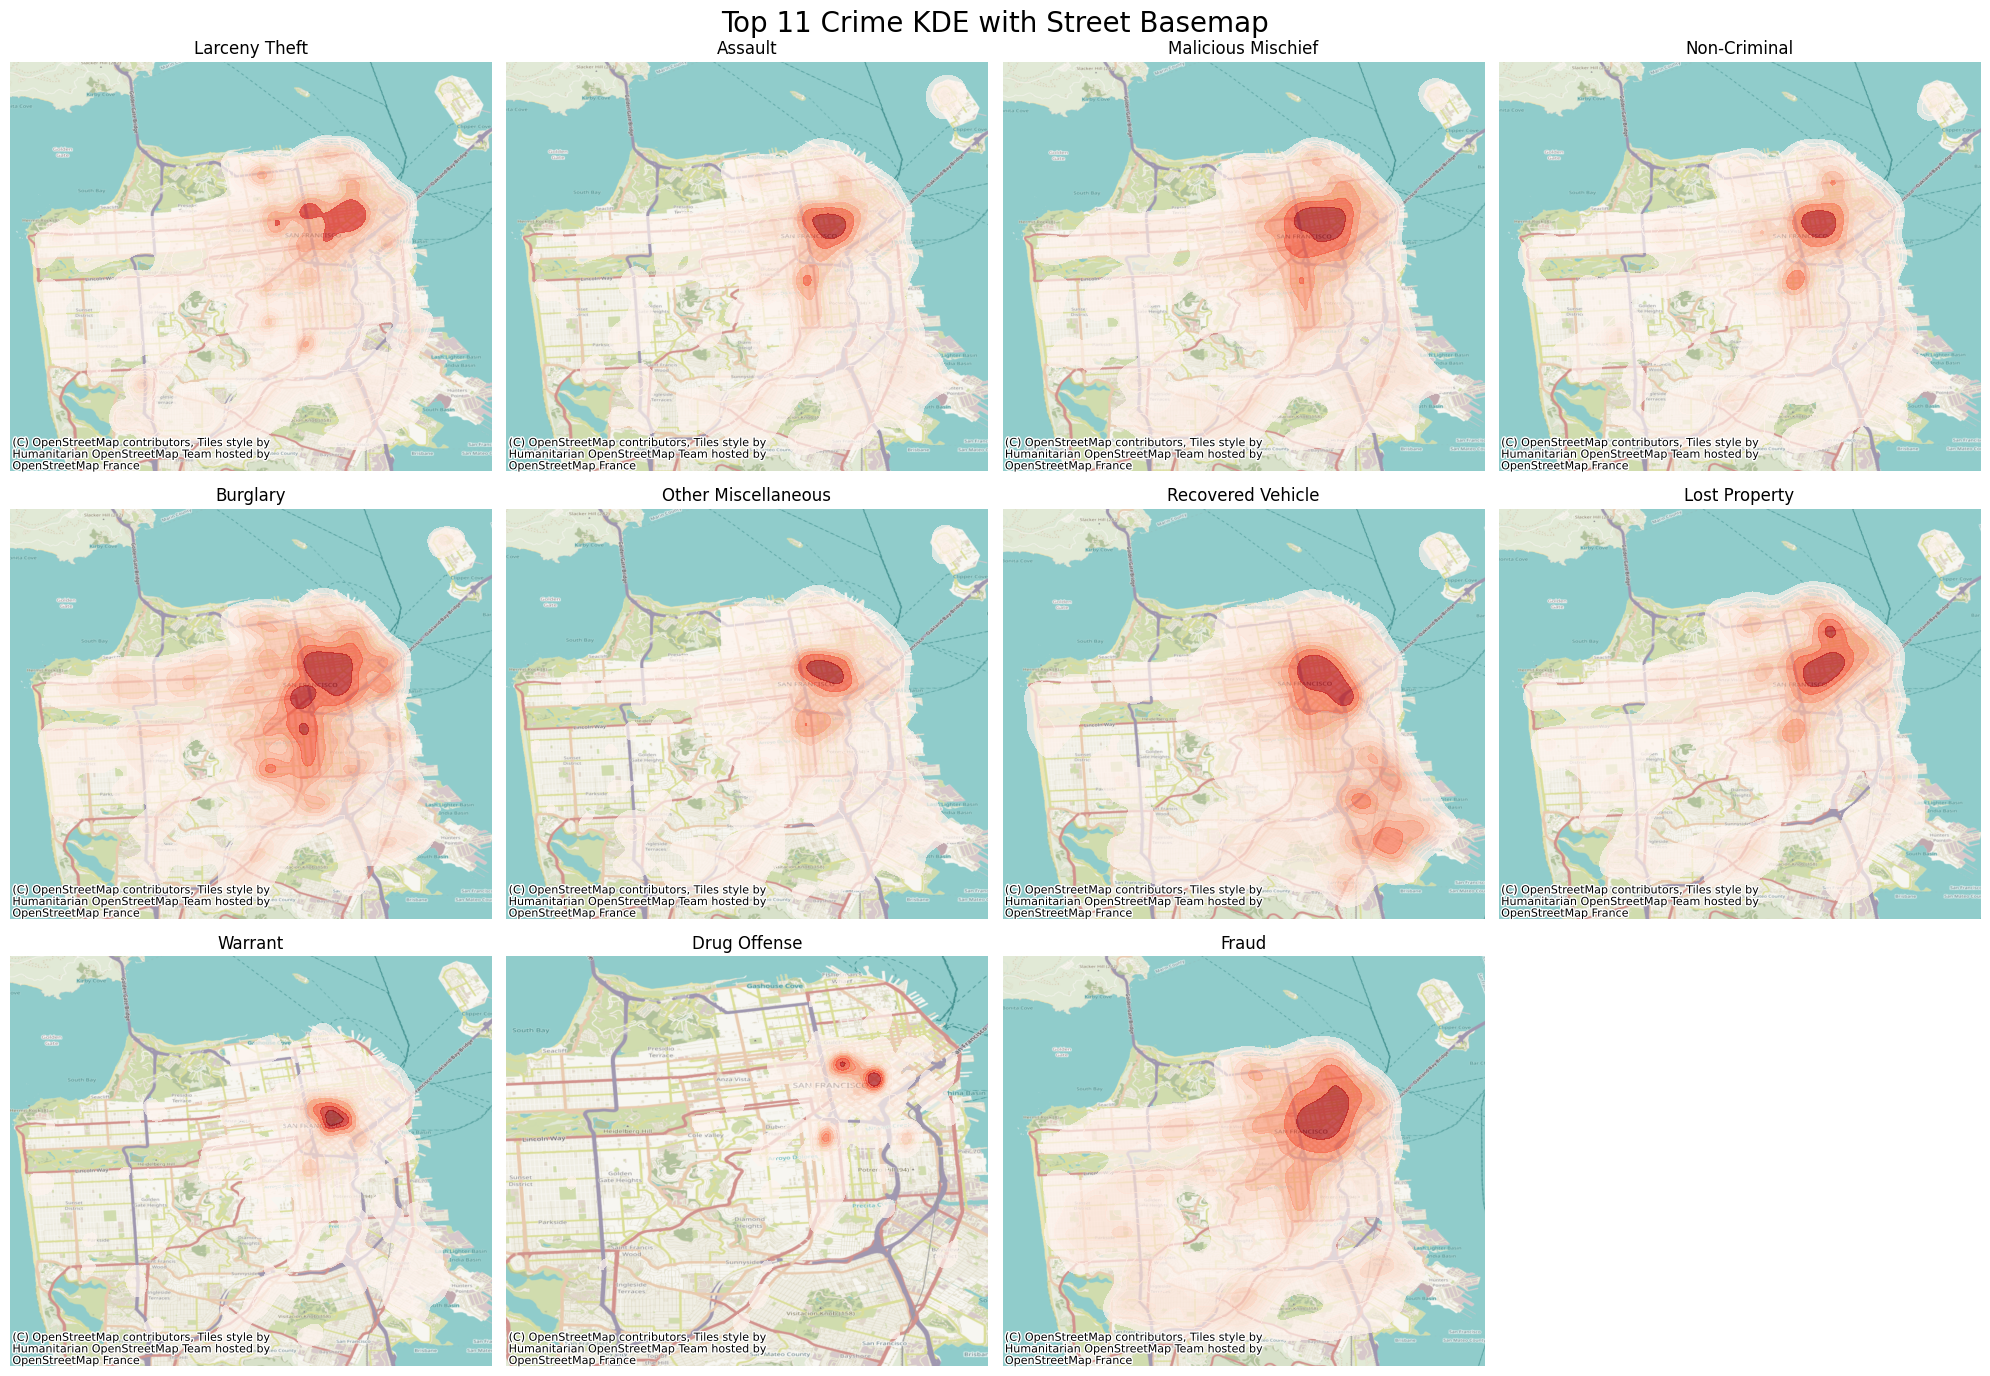

In [ ]:
gdf = gpd.GeoDataFrame(df_top11, geometry=gpd.points_from_xy(df_top11['longitude'], df_top11['latitude']), crs='EPSG:4326')
gdf = gdf.to_crs(epsg=3857)  

fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()

for i, crime in enumerate(top11):
    ax = axes[i]
    gdf_cat = gdf[gdf['incident_category'] == crime]

    x = gdf_cat.geometry.x
    y = gdf_cat.geometry.y

    sns.kdeplot(x=x, y=y, fill=True, ax=ax, cmap="Reds", bw_adjust=0.5, thresh=0.05, alpha=0.7)
    ax.set_title(crime)
    ctx.add_basemap(ax,  alpha=1.0)
    ax.set_axis_off()  
    
for j in range(len(top11), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Top 11 Crime KDE with Street Basemap", fontsize=20)
plt.tight_layout()
plt.savefig("outputs/crime_basemap.png")

## Monthly reports of the top 11 crimes in San Francisco

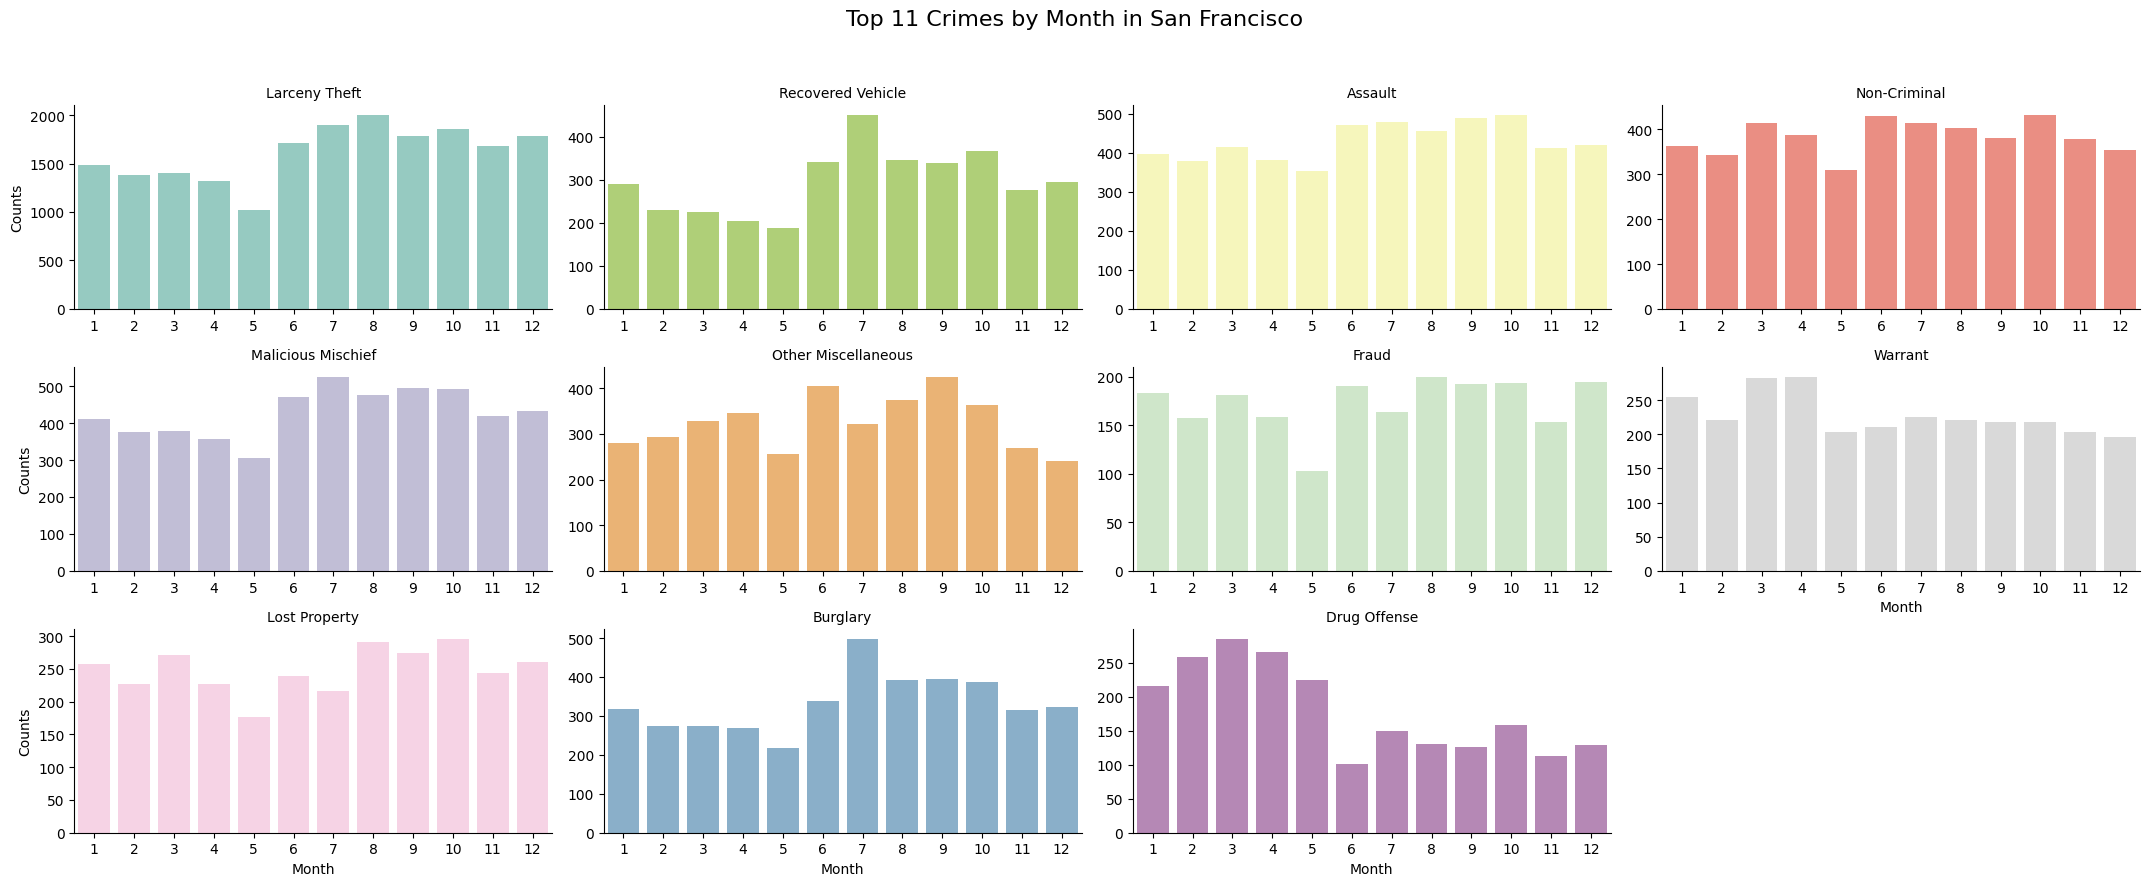

In [146]:
g = sns.FacetGrid(
    df_top11,
    col="incident_category",
    col_wrap=4,
    height=3,
    aspect=1.8,
    sharey=False,
    palette='husl'
)

category_colors = dict(zip(top11, sns.color_palette("Set3", len(top11))))

def plot_colored_barplot(data, color, **kwargs):
    cat = data['incident_category'].iloc[0]
    sns.countplot(data=data, x="incident_month", order=list(range(1, 13)), color=category_colors[cat], **kwargs)

g.map_dataframe(plot_colored_barplot)
g.set_axis_labels("Month", "Counts")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.set_xticks(range(0, 12))
    ax.set_xticklabels([str(i) for i in range(1, 13)])
    ax.tick_params(labelbottom=True)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Top 11 Crimes by Month in San Francisco", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("outputs/crime_month.png", dpi=300)
plt.show()

## Daily reports of the top 11 crimes in San Francisco

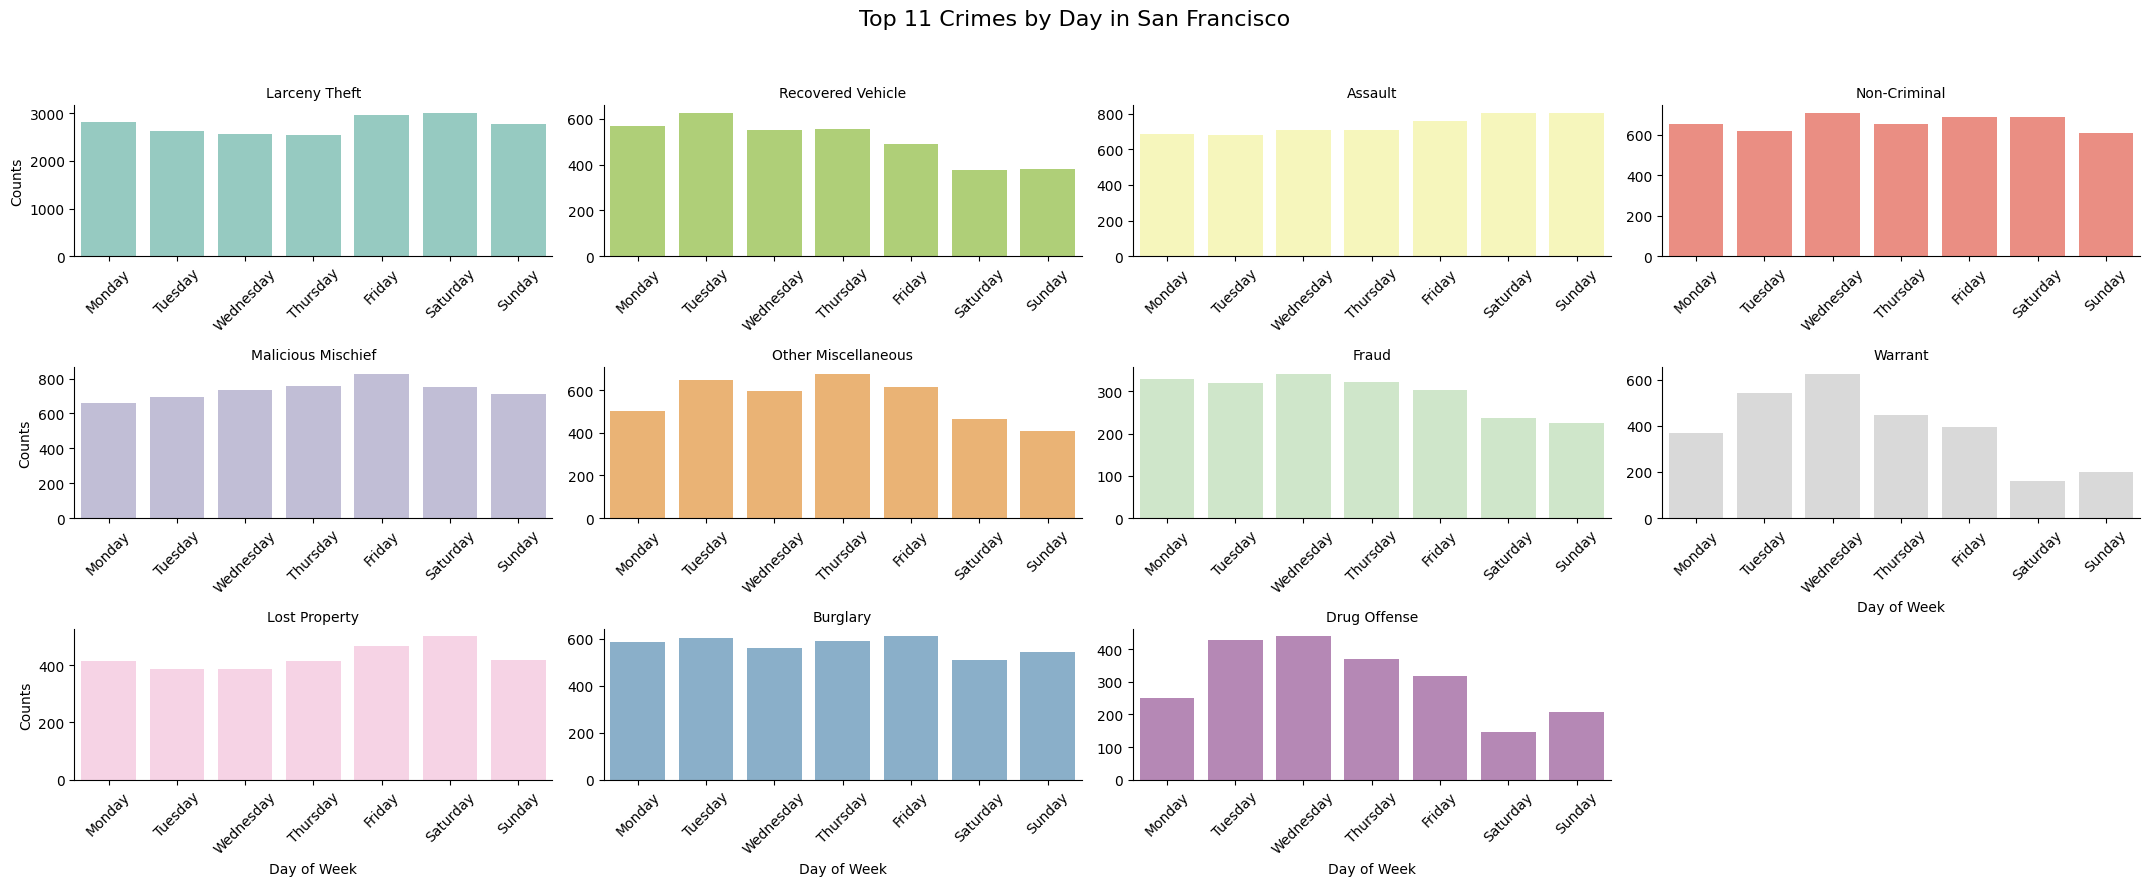

In [149]:
g = sns.FacetGrid(
    df_top11,
    col="incident_category",
    col_wrap=4,
    height=3,
    aspect=1.8,
    sharey=False,
    palette='husl'
)

category_colors = dict(zip(top11, sns.color_palette("Set3", len(top11))))

def plot_colored_barplot(data, color=None, **kwargs):
    cat = data['incident_category'].iloc[0]
    sns.countplot(
        data=data,
        x="incident_day_of_week",
        order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        color=category_colors[cat],
        **kwargs
    )

g.map_dataframe(plot_colored_barplot)

g.set_axis_labels("Day of Week", "Counts")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelbottom=True, labelrotation=45)


g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Top 11 Crimes by Day in San Francisco", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("outputs/crime_day.png", dpi=300)
plt.show()

## Hour reports of the top 11 crimes in San Francisco

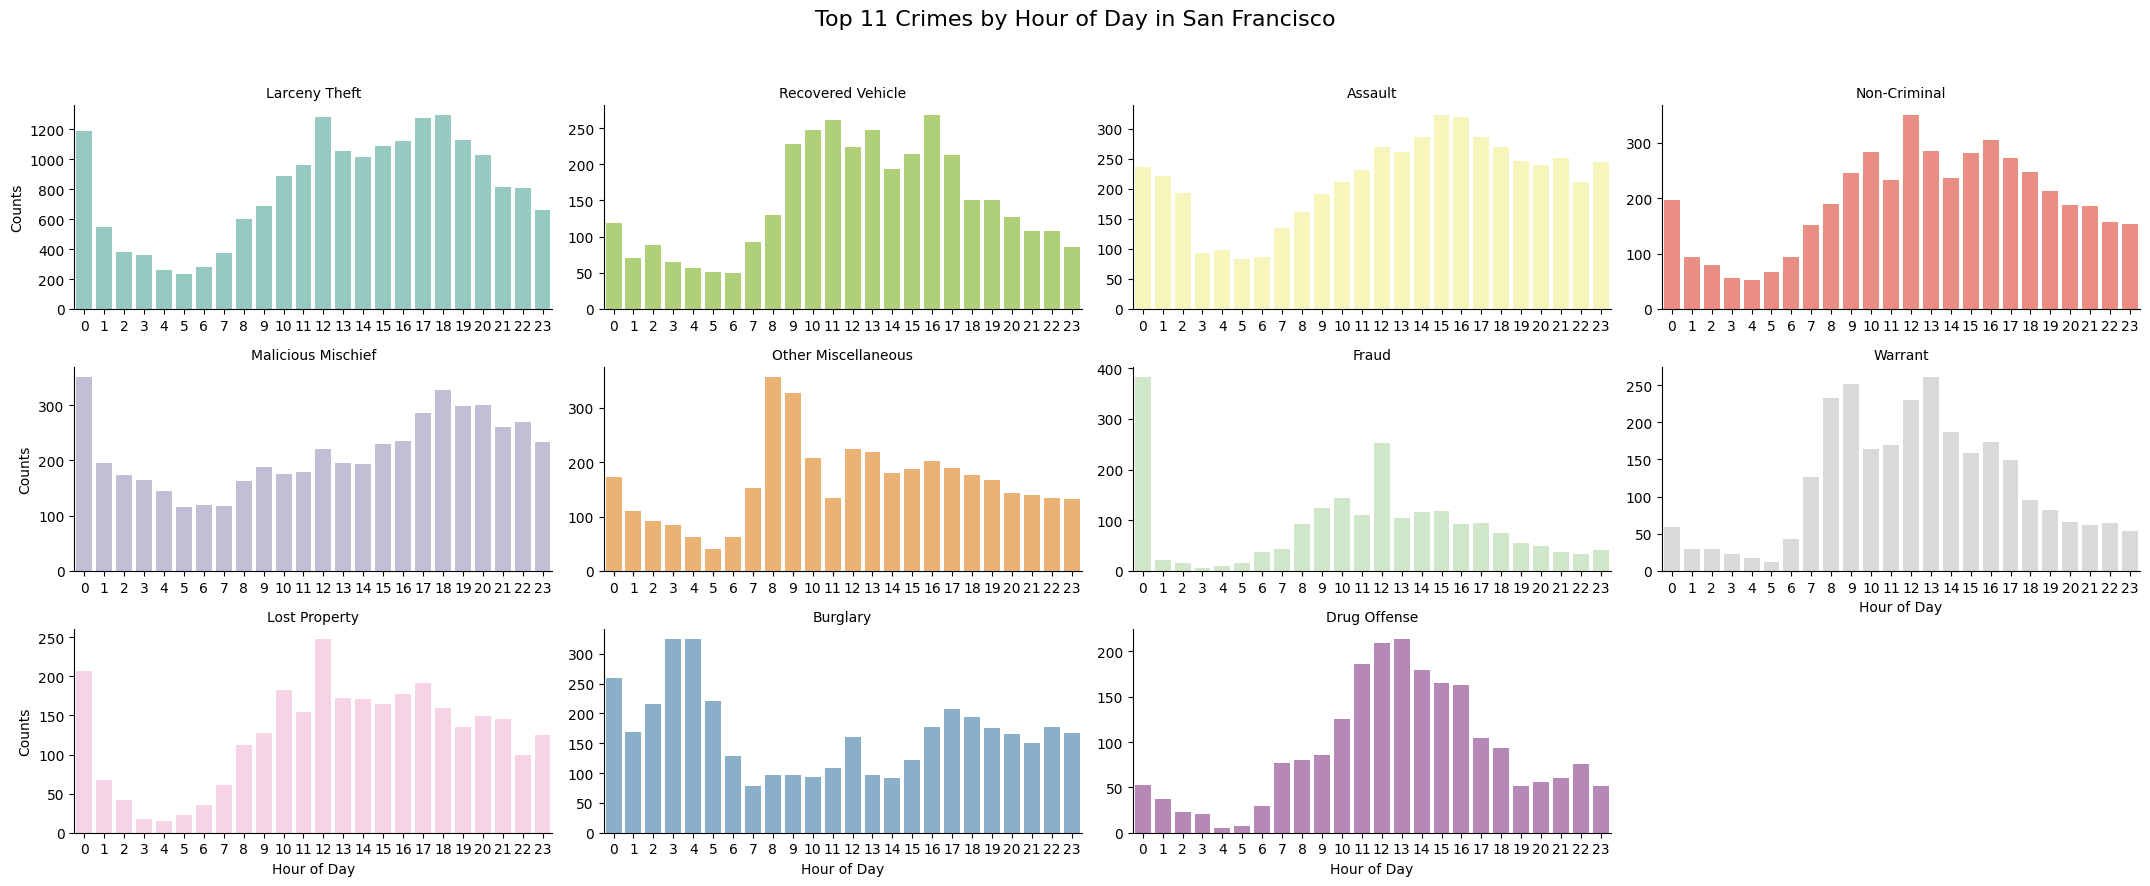

In [150]:
g = sns.FacetGrid(
    df_top11,
    col="incident_category",
    col_wrap=4,
    height=3,
    aspect=1.8,
    sharey=False,
    palette='husl'
)

category_colors = dict(zip(top11, sns.color_palette("Set3", len(top11))))

def plot_colored_hour_bar(data, color=None, **kwargs):
    cat = data['incident_category'].iloc[0]
    sns.countplot(
        data=data,
        x="incident_hour",
        order=list(range(24)),
        color=category_colors[cat],
        **kwargs
    )

g.map_dataframe(plot_colored_hour_bar)

g.set_axis_labels("Hour of Day", "Counts")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelbottom=True)
    ax.set_xticks(range(0, 24))
    ax.set_xticklabels([str(h) for h in range(24)], rotation=0)


g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Top 11 Crimes by Hour of Day in San Francisco", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("outputs/crime_hour.png", dpi=300)
plt.show()

## Seasonal patterns in data

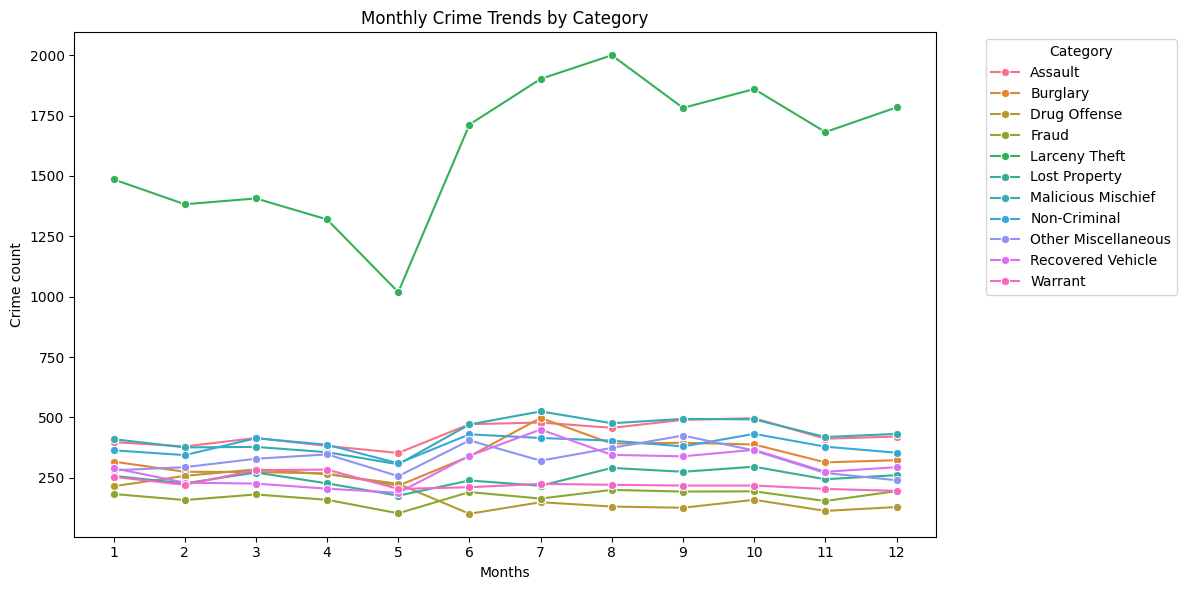

In [ ]:
monthly_counts = df_top11.groupby(['incident_category', 'incident_month']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_counts,
    x='incident_month',
    y='Count',
    hue='incident_category',
    marker='o',
    palette='husl'
)

plt.title("Monthly Crime Trends by Category")
plt.xlabel("Months")
plt.ylabel("Crime count")
plt.xticks(range(1, 13))
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("outputs/crime_month_lineplot.png", dpi=300)
plt.show()